I recently stumbled across a reddit link

> https://redd.it/4dlioz

to a (now 3-year-old) blog post about a method claimed to always yield better results than A/B testing for web optimization.

The large amount of upvotes this post gathered (now 235) really surprised me, given the tone, the vagueness of the many (unsupported) claims and the presence of easily spotted inaccuracies (e.g. A/B testing *can* handle more than two options at once and any such options can be added/removed at least as easily as in the method provided).

But let's not be narrow-minded and see what the multi-armed-bandit-based algorithm is and what it can do for the webmaster worried about his click through rates.

- [Part 1 - Introduction: "What are we talking about?"](#1.-What-are-we-talking-about?)
- [Part 2 - Model construction: "Numerical modelling and simulation"](#2.-Numerical-modelling-and-simulation)
- [Part 3 - Simulations: "Testing the claims"](#3.-Testing-the-claims)
- [Part 4 - Conclusions: "What does that mean in practice?"](#4.-What-does-that-mean-in-practice?)

1. What are we talking about?
--------------------------

### 1.1. Basics

People (among other things), tend to react in a predictable way "on average" to a given stimulus (a.k.a. **event**): e.g. most people tend to switch on the light on the *event* of entering a dark room.

Given a particular *event*, one can *measure* a particular **outcome**. For instance, on the *event* "going out on a rainy day", one can measure/count the particular *outcome* "number of persons carrying an umbrella". Similarly, one could measure the same *outcome* on a sunny day. 

### 1.2. Blog post case study

Instead of the weather, the blogger decided to study the effect of the "Buy Now!" button color on the click rate of that button. He chose buttons of 3 colors: 

- orange, 
- green and 
- white. 

The user are therefore subjected to three possible events:

- Getting the version of the website with the orange button (which we call event $A$);
- Getting that same website with a green button instead (event $B$);
- Same thing with a white button instead (event $C$).

The outcome (which we call $O$) that he wants to measure is the "number of clicks on that button".

But these raw numbers are not interesting by themselves: we would like to unveil something deeper, a kind of hidden truth about people behavior in general. That's why we have to resort to probabilities. So instead of analysing $O$, the number of clicks on the "Buy Now!" button, we will study $P(O)$, the probability that a user clicks on the button.

To be more specific, $P(O)$ is not that interesting either because our purpose is to determine *whether* a specific event gives a different outcome than the others, that is if $P(O)$ is different **given** that the user is subjected to either $A$, $B$ or $C$. These probabilities are written $P(O|A)$, $P(O|B)$ and $P(O|C)$ and are usually called "conversion rate" in the webservice parlance.

To sum up, we can define the following probabilities:

- $P(A)$: the probability of (some user) getting (the website with) the *orange* button;
- $P(B)$: the probability of getting the *green* button;
- $P(C)$: the probability of getting the *white* button;
- $P(O)$: the probability of **any** user clicking on the button;
- $P(O|A)$: the probability of (some user) clicking on the button **given** that button is *orange*;
- $P(O|B)$: the probability of clicking on the button **given** it is *green*;
- $P(O|C)$: the probability of clicking on the button **given** it is *white*;



### 1.3. A/B testing

[A/B testing](https://en.wikipedia.org/wiki/A/B_testing) is a method used to answer two different questions:

- *Are $P(O|A)$, $P(O|B)$, etc. significantly different?*
- *If so, what is this difference?*

To do that, we have to ensure that each event occurrence is equiprobable: in our case, that around as many users get an orange, a green or a white button at any given time, in other words, that $P(A) = P(B) = P(C)$. Why is this important? Why can't we provoke only event $A$ (i.e. use an orange button) for 1 month, then only $B$ for another month and then only $C$ for yet another month? Because there is no guarantee that $P(O|A)$, $P(O|B)$, etc. wouldn't change with time. Quite the contrary, very little voodoo magic is required to guess that people would tend to buy more things around christmas, so more people would come to the site, knowing exactly what they want and click on the "Buy Now!" button (in other words $P(O\text{ in december}) > P(O\text{ the rest of the year})$). By ensuring that $P(A) = P(B) = P(C)$, no one specific event is artificially favored.

Whether or not the difference between $P(O|A)$, $P(O|B)$ and $P(O|C)$ is significant is assessed by a statistical test (in that case, it would certainly be [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test)). This test assumes that the error on $P(O|X)$ (with $X$ any of the events $A$, $B$ or $C$) follows a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution#Probability_density_function).

Finally, **if** the differences are **proven** significant, we are allowed to select the "best performing" event and serve only that to the user (in that case, the button color which is associated with the highest probability of click).


### 1.4. Multi-armed-bandit-based method

One of the drawbacks of the A/B testing method is that even if one event yields a far better outcome than the others, we have to wait for our testing campaign to stop before actually analyse and use the results. That patience is required for sound reasons, the main one being that we designed our campaign in order to reach a certain amount of trust and precision in our results.

The multi-armed-bandit-based method proposed by the blogger just ignores that. It assumes that the $P(O|X)$ obtained through the method are significant and can be used to make a decision **at any given time** (even at the very start, when we have no actual data). Said more simply, $P(O|A)$, $P(O|B)$ and $P(O|C)$ are **assumed** to be different and that difference is **assumed** to be significant at any time.

By making these rather bold assumptions, we are allowed to make a single change in the A/B testing method:

> If $A$ is found to yield the highest probability of click: $$P(O|A) \geq P(O|B) \text{ and } P(O|A) \geq P(O|C)$$ at the impression $n$,
> then **set** $$P(A) > P(B) = P(C)$$ at the impression $n+1$ (an impression occurs each time a user connects to the website whether of not she clicks, it is sometimes called sample or trial).

This **inequality is actually the only difference** in the *data gathering stage* between the multi-armed bandit method and typical A/B testing. In the blog, the author devised quite a complicated scheme, by splitting the general web serving algorithm the into two phases with two different probability of occurence:

- One phase of *exploration* (happening 10% of the time in his example) in which any event can occur with the same probability (i.e. this is basically A/B testing in all its glory).
- One phase of *exploitation* (occurring 90% of the time in his example) in which the **favored** event is always served.

In practice, these two phases can be expressed as raw probabilities for a given event: 
$$P(\text{favored event}) = P(\text{exploitation}) + P(\text{disfavored event}) \quad \text{ and } \quad P(\text{disfavored event}) = \frac{P(\text{exploration})}{\text{number of events}}.$$

It is worth noting that our understanding of the blog post suggests that an actual statistical test is never ever performed but instead, the most favored event is considered the best one. 

### 1.5. Conclusion about the applicability of the multi-armed-bandit-based method

At this stage, we have already said most of what should matter to any reader about that proposed method: 

1. It is actually a **strategy** to maximize a specific outcome rather than a proper statistical method. In particular, the statistical part is either absent (as we understand it from the blog post) or completely identical to that of A/B testing, but applied on generally uneven samples.
2. This means the multi-armed-bandit method **cannot** outperform A/B testing to answer the question "is there a difference?".
3. As $P(O|X)$ is assumed significant at **any given time** (i.e. we make an important decision out of a single comparison without testing its significance), any underestimated $P(O|X)$ will be systematically disfavored so we will need a far longer time to get significant values.
4. The underlying distribution of errors on the disfavored event does not necessarily follow the beta distribution, which means that we can't trust Fisher's exact test with that strategy


In conclusion, if for any reason, we are fine with these (let's say, because we only want the best performing slot machine and the worst case scenario is that they all behave the same), then why not... This algorithm, is, after all, only a **strategy** to maximize reward, not really a testing method *per se*. But it is not clear at this stage that this strategy would outperform proper A/B testing with a factor of 2-3 (as claimed in the blog post).

2. Numerical modelling and simulation
----------------------------------

We understand that most points of the conclusion above are not straightforward to all. We would also like to see how much this strategy outperforms A/B testing (i.e. how many more clicks would be gathered in the long run).
This is why we are going to resort to numerical simulations to illustrate and justify them. We will proceed as follow:

1. Model the webserver as a function which returns (event) `'A'`, `'B'` or `'C'` (i.e. button of different colors) according to the normalized probabilities in `P_X` (a dictionnary mapping event $X$ to $P(X)$).
2. Model the behavior of people with a function returning whether or not a particular user has clicked on the button given its color and `P_O_X`: a dictionnary containing the "hidden truth", that is, the underlying exact probability that a user clicks on the button given the color, the conversion rate.
3. Model campaigns based on each strategy (A/B, MAB) to estimate the experimental $\tilde{P}(O|X)$ which is an estimate of the known $P(O|X)$.
4. Estimate whether the differences in $\tilde{P}(O|X)$ are significant (by using [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test)).

These models will be used in the next section to test various claims.

### 2.1. The webserver

The web server should provide websites which differ only by the color of a button. As we control the server, we can decide the individual probability of sending any of these colors: $P(X)$ with $X$ which is either $A$, $B$ or $C$.

    >>> import numpy as np
    >>> events = {"A": "got an orange button", "B": "got a green button", "C": "got a white button"}
    >>> P_X = {"A": 1/3, "B": 1/3, "C": 1/3}
    >>> def fetch_website_and_return_event(P_X):
    >>>     event_list = [c for c in events]
    >>>     probability_of_event = [P_X[event] for event in event_list]
    >>>     return np.random.choice(event_list, p=probability_of_event)

    >>> for user_number in range(100): # 100 users visit the website
    >>>     event = fetch_website_and_return_event(P_X)
    >>>     print("The user #%2d was subjected to event %s: she %s"%(user_number, event, events[event]))
    
    The user # 0 was subjected to event A: she got an orange button
    The user # 1 was subjected to event B: she got a green button
    [...]
    The user #98 was subjected to event C: she got a white button
    The user #99 was subjected to event A: she got an orange button

### 2.2. User clicking behavior (click through rate)

In a similar way, we can represent the behavior of the users by setting $P(O|X)$ (with $X$ which is either $A$, $B$ or $C$) and "drawing" individual outcomes from it:

    >>> P_O_X = {"A": 0.001, "B": 0.01, "C": 0.5}
    >>> def has_user_clicked_on_the_button(event, P_O_X):
    >>>     return np.random.uniform(low=0.0, high=1.0, size=None) < P_O_X[event]

    >>> for user_number in range(100):
    >>>     event = fetch_website_and_return_event(P_X)
    >>>     if has_user_clicked_on_the_button(event, P_O_X):
    >>>         has_clicked = "and clicked on it!"
    >>>     else:
    >>>         has_clicked = "and DIDN'T click on it!"
    >>>     print("The user #%2d %s"%(user_number, events[event]), has_clicked)

    The user # 0 got a white button and clicked on it!
    The user # 1 got a white button and DIDN'T click on it!
    [...]
    The user #98 got a white button and DIDN'T click on it!
    The user #99 got an orange button and DIDN'T click on it!
    

### 2.3. Campaigns

As we said, in A/B testing, $P(A) = P(B) = P(C)$, therefore the code we already shown above is already suited to this use case: all we have to do is to gather the results.

In the case of the multi-armed bandit, $P(O|X)$ (`P_O_X`) should be updated at each iteration/impression to favor the event which yields the best outcome at that time.

However, our partial model implementations are too slow to use in real code, that is why we actually provide strictly equivalent vectorized code for real testing purpose. 

In [1]:
import numpy as np
def AB_campaign(number_of_users, P_O_X, P_X=None):
    ordered_events = [event for event in P_O_X]
    if P_X:
        P_X = [P_X[event] for event in ordered_events]
    event_per_user = np.random.choice(ordered_events, p=P_X, size=number_of_users)
    click_proba_per_user = np.empty_like(event_per_user, dtype=np.float64)
    for event, proba in P_O_X.items():
        click_proba_per_user[event_per_user == event] = proba
    click_per_user = np.random.uniform(low=0.0, high=1.0, size=number_of_users) < click_proba_per_user
    return click_per_user, event_per_user

Rough timings comparing the given implementation and one based on the implementation in the section 2.2.

    >>> %timeit AB_campaign(100000, P_O_X)
    100 loops, best of 3: 17.3 ms per loop
    >>> %timeit naive_AB_campaign(100000, P_O_X)
    1 loop, best of 3: 8.51 s per loop
    
Now let's define the multi-armed bandit version in a similar way. The coefficient `f` corresponds to the $P(\text{Exploitation})$ as described in the blog post. Both the optional `click_hist` and `event_hist` are dictionaries with events as keys and the respective number of clicks ($O|X$) and event occurences from a previous run.

In [2]:
import numpy as np
def MultiArmedBandit_campaign(number_of_users, P_O_X, f=0.9, click_hist=None, event_hist=None):
    l = len(P_O_X)
    disfav = (1-f)/l
    fav = f + disfav
    # Let's put everything in lists and use indices instead of dict/event name
    indices = np.array(list(range(l)))
    event_list = np.array([event for event in P_O_X]) # provide an order
    P_O_X_list = np.array([P_O_X[event] for event in event_list])
    
    # Let's keep the sum of clicks for each
    clicks_per_X = np.ones_like(event_list, dtype=np.int)
    events_per_X = np.ones_like(event_list, dtype=np.int)
    if click_hist:
        c = [click_hist[event] for event in event_list]
        clicks_per_X *= c
    if event_hist:
        e = [event_hist[event] for event in event_list]
        events_per_X *= e
    
    # Generate all the random draws here and now 
    rdm_click = np.random.uniform(low=0.0, high=1.0, size=number_of_users)
    
    # Pregenerate all the lists of random number from the start
    # Each column i corresponds to favoring the ith event
    # Bad for memory, good for speed!
    P_X_fav = np.zeros((number_of_users, l), dtype=np.int)
    for i in range(l):
        P_X_list = [disfav] * l
        P_X_list[i] = fav
        P_X_fav[:, i] = np.random.choice(indices, p=P_X_list, size=number_of_users)
    
    # Init all the relevant arrays
    event_idx_per_user = np.zeros(number_of_users, dtype=np.int)
    fav_idx_per_user = np.zeros(number_of_users, dtype=np.int)
    click_per_user = np.zeros(number_of_users, dtype=np.bool)
    
    # Now perform the expensive loop
    for user_number, cmp_click in enumerate(rdm_click):
        # Get event to favor
        fav_idx = np.argmax(clicks_per_X/events_per_X)
        # Get event idx depending on fav:
        # just extract it from the correct column
        # of pregenerated random events
        event_idx = P_X_fav[user_number, fav_idx]
        
        # Update relevant arrays and cumulated sums
        event_idx_per_user[user_number] = event_idx
        fav_idx_per_user[user_number] = fav_idx
        events_per_X[event_idx] += 1
        has_clicked = (cmp_click < P_O_X_list[event_idx])
        clicks_per_X[event_idx] += has_clicked
        click_per_user[user_number] = has_clicked
        
    # Finally convert indices into event names
    event_per_user = np.empty_like(event_idx_per_user, dtype=np.str)
    fav_per_user = np.empty_like(fav_idx_per_user, dtype=np.str)
    for idx, event in enumerate(event_list):
        event_per_user[event_idx_per_user == idx] = event
        fav_per_user[fav_idx_per_user == idx] = event
    return click_per_user, event_per_user, fav_per_user

    >>> %timeit MultiArmedBandit_campaign(10000, P_O_X)
    10 loops, best of 3: 133 ms per loop

### 2.4. Fisher's exact test

The last element which we need is a way to determine whether the measured $\tilde{P}(O|X)$ are significant. As stated previously, [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test)) is usually used to answer such a question.

To do that, we must first create a contingency table giving the number of clicks and the number of "non-click" per event, for instance:

<table> 
    <tr>
        <td></td>
        <td>click</td>
        <td>non-click</td>
    </tr>
    <tr>
        <td>A</td>
        <td>15</td>
        <td>26</td>
    </tr>
    <tr>
        <td>B</td>
        <td>541</td>
        <td>432</td>
    </tr>
</table>

Then the test itself is performed (here, we will be using `fisher_exact` from `scipy.stats`). There are a few way to handle the results. For what we have to do here, we are going to set the significance from the start and if the $p$-value given by the test is smaller, the difference will be considered significant.

In [3]:
from scipy.stats import fisher_exact 
def get_nclicks_nevents(clicks, events, event_name):
    mask = (events == event_name)
    nclicks = np.sum(clicks[mask])
    nevents = np.sum(mask)
    return nclicks, nevents

def contingency_tbl_2x2(clicks, events, A="A", B="B"):
    A_nclicks, A_nevents = get_nclicks_nevents(clicks, events, A)
    B_nclicks, B_nevents = get_nclicks_nevents(clicks, events, B)
    return np.array([
                    [A_nclicks, A_nevents-A_nclicks],
                    [B_nclicks, B_nevents-B_nclicks]
        ])

def is_significant(clicks, events, A="A", B="B", significance=0.05):
    oddsratio, p = fisher_exact(contingency_tbl_2x2(clicks, events, A, B))
    return p < significance

A last step would be to determine the minimum sample size guarantee the detection of a given difference. This is beyond the scope of this article and we will only use the following result:

To reliably detect a difference of 5% from an original conversion rate $P(O|X) = 10$% we need around $1500$ users/trials/impressions per event. More precisely,

    >>> P_O_X = {"A": 0.1, "B": 0.15}
    >>> AB_campaign(1500 * len(P_O_X), P_O_X)
    
should allow us to determine that $P(O|B) > P(O|A)$ with a significance degree of $1$% and a statistical power of $95$%, that is that we have only $1$% chance of finding there is a difference while there is none and $100-95 = 5$% chance of missing an existing difference.

In [4]:
M = 600
P_O_X = {"A": 0.1, "B": 0.15}
significance = []
for i in range(M):
    clicks, events = AB_campaign(1500*len(P_O_X), P_O_X)
    significance.append(is_significant(clicks, events, significance=0.01))
    
print("We should expect missing around 5%% of the differences: missed %.2f%% this time."%(100-np.sum(significance)*100/M))

P_O_X = {"A": 0.1, "B": 0.1}
significance = []
for i in range(M):
    clicks, events = AB_campaign(1500*len(P_O_X), P_O_X)
    significance.append(is_significant(clicks, events, significance=0.01))
    
print("We should expect wrongly finding around 1%% of them different: found %.2f%% this time."%(np.sum(significance)*100/M))

We should expect missing around 5% of the differences: missed 5.00% this time.
We should expect wrongly finding around 1% of them different: found 1.00% this time.


3. Testing the claims
-----------------------

We, and the author of the blog, made quite a few claims that we want to explore.

### 3.1. MAB is a strategy, not a proper statistical method

No need for fancy calculations there: there is no statistics whatsoever. If it is found that $x > y$, then $x$ is considered greater than $y$ by the method. Nothing more.

### 3.2. MAB cannot outperform A/B testing to answer the question "is there a difference?"

No rhetorical views here: only calculations. Let's run multiple campaigns with different values of $P(O|X)$ and see how many times the differences are found significant...

    >>> P_O_X = {"A": 0.1, "B": 0.15, "C": 0.15}
    >>> P_O_X = {"A": 0.15, "B": 0.15, "C":0.15}
    >>> P_O_X = {"A": 0.4, "B": 0.45, "C": 0.45}


In [5]:
M = 100
P_O_X_list = [
    {"A": 0.15, "B": 0.15},
    {"A": 0.1, "B": 0.15},
    {"A": 0.4, "B": 0.2}
]
significance_AB = [[] for p in P_O_X_list]
significance_MAB = [[] for p in P_O_X_list]
for count in range(M):
    for i, P_O_X in enumerate(P_O_X_list):
        # AB testing
        clicks, events = AB_campaign(1500*len(P_O_X), P_O_X)
        significance_AB[i].append(is_significant(clicks, events, significance=0.01))
        # MAB strategy
        clicks, events = MultiArmedBandit_campaign(1500*len(P_O_X), P_O_X)[:2]
        significance_MAB[i].append(is_significant(clicks, events, significance=0.01))
  
print("Identical:")
print("    - AB: found a unexisting difference in %.2f%% of the campaigns."%(np.sum(significance_AB[0])*100./M))
print("    - MAB: found a unexisting difference in %.2f%% of the campaigns."%(np.sum(significance_MAB[0])*100./M))

print("Small differences:")
print("    - AB: missed an existing difference in %.2f%% of the campaigns."%(100-np.sum(significance_AB[1])*100./M))
print("    - MAB: missed an existing difference in %.2f%% of the campaigns."%(100-np.sum(significance_MAB[1])*100./M))

print("Large differences:")
print("    - AB: missed an existing difference in %.2f%% of the campaigns."%(100-np.sum(significance_AB[2])*100./M))
print("    - MAB: missed an existing difference in %.2f%% of the campaigns."%(100-np.sum(significance_MAB[2])*100./M))

Identical:
    - AB: found a unexisting difference in 1.00% of the campaigns.
    - MAB: found a unexisting difference in 2.00% of the campaigns.
Small differences:
    - AB: missed an existing difference in 3.00% of the campaigns.
    - MAB: missed an existing difference in 63.00% of the campaigns.
Large differences:
    - AB: missed an existing difference in 0.00% of the campaigns.
    - MAB: missed an existing difference in 0.00% of the campaigns.


Using the given algorithm with a somewhat larger number of repetitions (`M = 2000`), we obtained:

    Identical:
        - AB: found a unexisting difference in 0.80% of the campaigns.
        - MAB: found a unexisting difference in 1.10% of the campaigns.
    Small differences:
        - AB: missed an existing difference in 4.70% of the campaigns.
        - MAB: missed an existing difference in 67.20% of the campaigns.
    Large differences:
        - AB: missed an existing difference in 0.00% of the campaigns.
        - MAB: missed an existing difference in 0.60% of the campaigns.
        
which clearly shows that the A/B testing data gathering is better than the one of MAB in the sense that its detection power is better. More specifically, where the sample size is barely enough to garantee $5$% of errors in A/B testing, MAB makes it far worse at above $50$%.

How is that coherent with MAB *assuming* difference? Well, the algorithm itself assumes that there is a significant difference. This does not mean that it is. 

This assumption, from the algorithm side, is what explains that it will need a longer time (actually, more samples) to reach a representative value: the favored event gets defined better and better (more precise $P(O|X)$), however the disfavored events do not. On average, it is more efficient to evenly provide events than favoring one like this. This is one reason why A/B testing is always better here. Another reason will be given in the following subsection.


### 3.3. The underlying probability density function does not follow the beta distribution

Knowing the underlying density function is useful in a lot of cases. This is what allows us to use Fisher's test to have an idea of the significance of our results. This is also important to predict what results are expected. Here, we can run a large number of campaigns to estimate the "experimental" density function. This density function can be compared to the theoretical one: the beta function.

We could use histograms as an estimate of the experimental density function but we chose [Gaussian kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) instead which provides a natural way of interpolating values and does converge faster with the number of repetitions (especially knowing that the beta density function can be very similar to a Gaussian for central values). 

In [6]:
from scipy.stats import beta, gaussian_kde
def experimental_error(x, X, O_X):
    # Gaussian kernel density estimation
    # Defaults to using Scott's rule
    # which is optimal if the underlying
    # distribution is roughly Gaussian
    y = gaussian_kde(O_X/X).evaluate(x)
    return y

def theoretical_error(x, X, O_X):
    # use Beta from scipy
    # X: individual events (A, B, C)
    # corresponding to a (orange, green, white) button
    # O_X: number of clicks given X (i.e. given the color)
    k = np.mean(O_X)
    n = np.mean(X)
    a = k + 1
    b = n - k + 1
    y = beta.pdf(x, a, b)
    return y

In [7]:
# Setup the plots
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt, rcParams
rcParams['figure.figsize'] = (12,4)
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 14
rcParams['legend.fontsize'] = 14
import seaborn as sns
sns.set_style("white")

N = 1000 # Number of samples/users/etc. per campaign
M = 4000 # Number of campaigns

# Set equal conversion rates 
P_O_X = {"A": 0.1, "B": 0.1}

# Set the interpolation grid
x = np.linspace(0, 0.5, 2000)

# Set the output varialbles as dicts(event_name -> P(O|X) array of M elements)
AB_est_nclicks_identical = {event: np.zeros(M) for event in P_O_X}
MAB_est_nclicks_identical = {event: np.zeros(M) for event in P_O_X}
AB_est_nevents_identical = {event: np.zeros(M) for event in P_O_X}
MAB_est_nevents_identical = {event: np.zeros(M) for event in P_O_X}

# Do all the calculations from the start
for count in range(M):
    AB_clicks, AB_events = AB_campaign(N, P_O_X)[:2]
    MAB_clicks, MAB_events = MultiArmedBandit_campaign(N, P_O_X)[:2]
    for event in P_O_X:
        AB_est_nclicks_identical[event][count], AB_est_nevents_identical[event][count] = get_nclicks_nevents(AB_clicks, AB_events, event_name=event)
        MAB_est_nclicks_identical[event][count], MAB_est_nevents_identical[event][count] = get_nclicks_nevents(MAB_clicks, MAB_events, event_name=event)

# Sum over all events to get the 'averaged' effect.
y_theo_AB = np.zeros_like(x)
y_theo_MAB = np.zeros_like(x)
y_exp_AB = np.zeros_like(x)
y_exp_MAB = np.zeros_like(x)
for event in P_O_X:
    y_theo_AB += theoretical_error(x, AB_est_nevents_identical[event], AB_est_nclicks_identical[event])
    y_exp_AB += experimental_error(x, AB_est_nevents_identical[event], AB_est_nclicks_identical[event])
    y_theo_MAB += theoretical_error(x, MAB_est_nevents_identical[event], MAB_est_nclicks_identical[event])
    y_exp_MAB += experimental_error(x, MAB_est_nevents_identical[event], MAB_est_nclicks_identical[event])

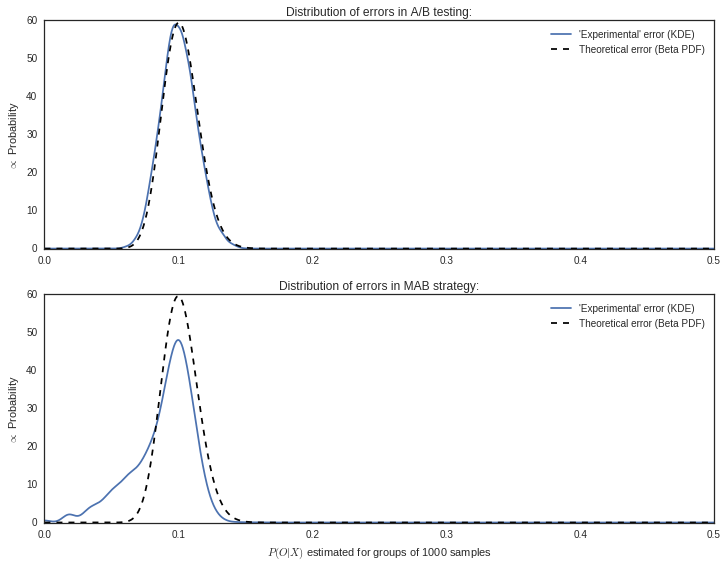

In [8]:
# Actual plotting

fig = plt.figure(figsize=(12, 9))
ax_AB = fig.add_subplot(211)
ax_MAB = fig.add_subplot(212)

ax_AB.set_title("Distribution of errors in A/B testing:")
ax_MAB.set_title("Distribution of errors in MAB strategy:")

ax_AB.set_ylabel("$\propto$ Probability")

ax_MAB.set_xlabel("$P(O|X)$ estimated for groups of %d samples"%N)
ax_MAB.set_ylabel("$\propto$ Probability")

ax_AB.plot(x, y_exp_AB, label="'Experimental' error (KDE)")
ax_AB.plot(x, y_theo_AB, "k--", label="Theoretical error (Beta PDF)")
ax_AB.legend(loc=0)

ax_MAB.plot(x, y_exp_MAB, label="'Experimental' error (KDE)")
ax_MAB.plot(x, y_theo_MAB, "k--", label="Theoretical error (Beta PDF)")
ax_MAB.legend(loc=0)

That nails it: the underlying distributions are different. You can also slightly alter the code to convince yourself that these are similar to *per event* distributions. The problem now is that Fisher's test assumes the "theoretical" distribution, not the "experimental" one. So you may very well be in a case where $P(O|A) = 0.1$ and $P(O|B) < 0.07$ and Fisher's test would help you conclude that there is indeed a difference while there is not. 

How can we explain that there is a tail like this? Let's alter the code to separate mostly favored events from disfavored ones:

In [9]:
N = 1000 # Number of samples/users/etc. per campaign
M = 4000 # Number of campaigns

# Set equal conversion rates 
P_O_X = {"A": 0.1, "B": 0.1}

# Set the interpolation grid
x = np.linspace(0, 0.5, 2000)

# Set the output varialbles as dicts(event_name -> P(O|X) array of M elements)
fav_est_nclicks_identical = np.zeros(M)
disfav_est_nclicks_identical = np.zeros(M)
fav_est_nevents_identical = np.zeros(M)
disfav_est_nevents_identical = np.zeros(M)

# Do all the calculations from the start
previous_was_favored = False
event_list = [event for event in P_O_X]
A, B = event_list
for count in range(M):
    MAB_clicks, MAB_events, MAB_fav = MultiArmedBandit_campaign(N, P_O_X)[:3]
    if np.sum(MAB_fav == A) >= N/2:
        # A was favored
        fav_event, disfav_event = A, B
    else:
        # B was favored
        fav_event, disfav_event = B, A
    fav_est_nclicks_identical[count], fav_est_nevents_identical[count] = get_nclicks_nevents(MAB_clicks, MAB_events, event_name=fav_event)
    disfav_est_nclicks_identical[count], disfav_est_nevents_identical[count] = get_nclicks_nevents(MAB_clicks, MAB_events, event_name=disfav_event)

for event in P_O_X:
    y_theo_fav = theoretical_error(x, fav_est_nevents_identical, fav_est_nclicks_identical)
    y_exp_fav = experimental_error(x, fav_est_nevents_identical, fav_est_nclicks_identical)
    y_theo_disfav = theoretical_error(x, disfav_est_nevents_identical, disfav_est_nclicks_identical)
    y_exp_disfav = experimental_error(x, disfav_est_nevents_identical, disfav_est_nclicks_identical)

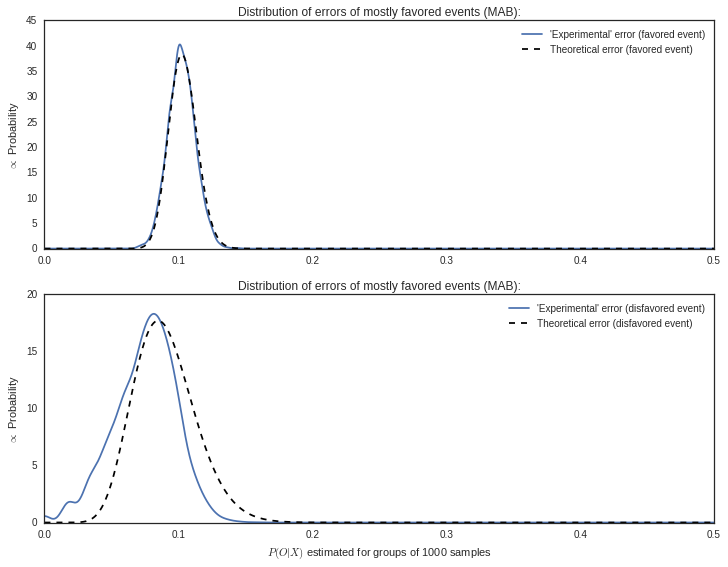

In [10]:
# Actual plotting

fig = plt.figure(figsize=(12, 9))
ax_fav = fig.add_subplot(211)
ax_disfav = fig.add_subplot(212)

ax_fav.set_title("Distribution of errors of mostly favored events (MAB):")
ax_disfav.set_title("Distribution of errors of mostly favored events (MAB):")

ax_fav.set_ylabel("$\propto$ Probability")

ax_disfav.set_xlabel("$P(O|X)$ estimated for groups of %d samples"%N)
ax_disfav.set_ylabel("$\propto$ Probability")

ax_fav.plot(x, y_exp_fav, label="'Experimental' error (favored event)")
ax_fav.plot(x, y_theo_fav, "k--", label="Theoretical error (favored event)")
ax_fav.legend(loc=0)

ax_disfav.plot(x, y_exp_disfav, label="'Experimental' error (disfavored event)")
ax_disfav.plot(x, y_theo_disfav, "k--", label="Theoretical error (disfavored event)")
ax_disfav.legend(loc=0)

So we proved that the distribution of favored events does follow the beta distribution while the mostly disfavored events do not. Actually, it is now obvious that the mode (i.e. the highest point of the distribution) of the disfavored events is not located at $0.1$, but below: not only did the multi-armed bandit strategy assume the difference, it did introduce one. 
Restart the calculation as many times as you wish, go ahead: the mostly disfavored events will always yield **lower** values than the real ones. Also try different conversion rate, you should observe the exact same thing: different distributions from the expected one as well as an underestimated "true" value.

Why not just throw more samples at it? Go ahead, do it. You should see that even a sample size $0.933333/0.066666 = 14$ times bigger is not enough to get the distribution right. Yet $14$ times bigger is exactly what we need to get the exact same statistical power in the new disfavored case compared to the favored case as illustrated. This shows that the distribution of the disfavored event is really skewed and no amount of extra samples is going to change that! 

Why is that? Well, just think of it this way: the problem is that **you** choose **when** to change $P(X)$ **using** the results themselves. Likewise, we could toss a coin and decide to toss the coin a second time *if, and only if* we get a head. Nobody would be the least surprised that we obtained more tails than heads then, even if the coin is known to be fair. This is the same kind of problem here, if only more subtle... The algorithm actually *favors* **underestimated** probabilities for the disfavored events. 

This bias also explains why A/B testing always performs better to determine the existence and the value of the differences: the multi-armed bandit strategy generally overestimates the differences by a hard-to-estimate amount, even with sample sizes that would be considered overkill in A/B testing. The multi-armed bandit strategy was just not design to answer these questions.

### 3.4. The christmas effect, or varying $P(O|X)$

Let's imagine that you want to start a one-month campaign which just happens to start by the middle of November, expecting $1000$ impressions during the first two weeks and $2000$ impressions during the last weeks (Christmas powa). Now, let's assume that the real conversion rates in November happen to be:

    >>> P_O_X_nov = {"A": 0.10, "B": 0.20}
    
and in December:

    >>> P_O_X_dec = {"A": 0.35, "B": 0.40}
    
so that $B$ is clearly always the best solution in spite of the slight increase in December (caused by christmas).

Let's model that:

In [11]:
P_O_X_nov = {"A": 0.10, "B": 0.15}
P_O_X_dec = {"A": 0.20, "B": 0.25}

M = 1000

which_AB_significant = [] 
which_MAB_significant = []
print("Christmas with always better 'B':")
# A/B testing
print(" Simulating A/B...", end="")
for campaign in range(M):
    AB_clicks_nov, AB_events_nov = AB_campaign(1000, P_O_X_nov)[:2]
    AB_clicks_dec, AB_events_dec = AB_campaign(2000, P_O_X_dec)[:2]
    
    AB_clicks = np.append(AB_clicks_nov, AB_clicks_dec)
    AB_events = np.append(AB_events_nov, AB_events_dec)
    
    if is_significant(AB_clicks, AB_events):
        nclicks_A, nevents_A = get_nclicks_nevents(AB_clicks, AB_events, "A")
        nclicks_B, nevents_B = get_nclicks_nevents(AB_clicks, AB_events, "B")
        ratio_A = nclicks_A/nevents_A
        ratio_B = nclicks_B/nevents_B
        if ratio_A > ratio_B:
            which_AB_significant.append("A")
        elif ratio_A < ratio_B:
            which_AB_significant.append("B")
        else:
            print("AB: We have a problem here: the ratios cannot be equal if the difference is significant.")
print(" Finished")
    
# MAB strategy
print(" Simulating Multi-armed Bandit...", end="")
for campaign in range(M):
    MAB_clicks_nov, MAB_events_nov = MultiArmedBandit_campaign(1000, P_O_X_nov)[:2]
    nclicks_A, nevents_A = get_nclicks_nevents(MAB_clicks_nov, MAB_events_nov, event_name="A")
    nclicks_B, nevents_B = get_nclicks_nevents(MAB_clicks_nov, MAB_events_nov, event_name="B")
    click_hist = {"A": nclicks_A, "B": nclicks_B} # We don't want to restart from scratch 
    event_hist = {"A": nevents_A, "B": nevents_B} # but to do as if P_O_X was changed in the middle
    MAB_clicks_dec, MAB_events_dec = MultiArmedBandit_campaign(2000, P_O_X_dec, click_hist=click_hist, event_hist=event_hist)[:2]
    
    MAB_clicks = np.append(MAB_clicks_nov, MAB_clicks_dec)
    MAB_events = np.append(MAB_events_nov, MAB_events_dec)
    if is_significant(MAB_clicks, MAB_events):
        if ratio_A > ratio_B:
            which_MAB_significant.append("A")
        elif ratio_A < ratio_B:
            which_MAB_significant.append("B")
        else:
            print("MAB: the ratios cannot be equal if the difference is significant.")
print(" Finished")
print()
print("A/B testing:")
print("    - found the result significant %.1f%% of the time."%(100.*len(which_AB_significant)/M))
print("    - found the correct result %.1f%% of the time."%(100.*np.sum(np.asarray(which_AB_significant)=="B")/len(which_AB_significant)))

print("MAB strategy:")
print("    - found the result significant %.1f%% of the time."%(100.*len(which_MAB_significant)/M))
print("    - found the correct result %.1f%% of the time."%(100.*np.sum(np.asarray(which_MAB_significant)=="B")/len(which_MAB_significant)))


Christmas with always better 'B':
 Simulating A/B... Finished
 Simulating Multi-armed Bandit... Finished

A/B testing:
    - found the result significant 92.4% of the time.
    - found the correct result 100.0% of the time.
MAB strategy:
    - found the result significant 61.5% of the time.
    - found the correct result 100.0% of the time.


Remarquably, the multi-armed bandit strategy behaves and adapts well. The only thing is that the difference was found significant only around $65$% of the time. We expected that: remember that the less promising event is underrepresented and we have already shown that 

1. this strategy does not beat A/B testing on stating whether the differences are significant;
2. and that Fisher's test is not very well suited to analyze results obtained from that strategy. 

Now, we could tweak $P(O|X)$ to reduce the relative difference. In that case, we could see that the multi-armed bandit strategy would seem to give a higher proportion of significant results than A/B testing. These would actually be false positive: the event selected might be the correct one, but we cannot say that we trust this result at a level of significance of $99$%. We already explained and illustrated this problem in the part about skewed distributions.

4. What does that mean in practice?
----------------------------------

### 4.1. Can we use it?

The multi-armed bandit strategy is generaly fine for web optimization.

> Really?! But all these statistical considerations and simulations to show the limits of the method and it turns out to be fine?

Most likely yes, precisely because these limits were found not relevant to web optimization. Basically, if you are fine saying:

> *We determined that $A$ yields **similar or better** results than $B$, $C$, etc.*

then the multi-armed bandit strategy might be worth a try. If you want to say:

> *We are pretty sure that $A$ yields **better** results than $B$, $C$, etc.*

then A/B testing is a much better option (remember, even if you ended up gathering enough data for the difference to be "statistically significant" in the A/B framework, you cannot conclude within the multi-armed bandit framework because the distribution **is** skewed).

This skewness is only ever a problem in two cases:

- if the real conversion rates are actually *the same*;
- if what we are interested in *quantifying* the differences.

If there was a difference from the start, it is necessarily overestimated by the strategy, which is generally not a problem.

In other words, A/B testing is the correct method to answer "is there a difference? if so, how much is it?" whereas the multi-armed method is only a strategy to find an event yielding the best results ("best" can be "same as the others"). Of course you knew that, we said it from the start. But now you have proofs and tools.


### 4.2. A word about the original blog post: is multi-armed bandit always better than A/B testing?

The strategy given in the original blog post turned out to be correct even though there were a lot of mistakes in the post itself... Yes, the distribution of values is skewed by the method; yes, we can use more than two options in A/B testing; yes, we can add or remove options as we like (well, almost); no, this cannot be used in clinical trials; no, you can't set it an forget it (if you want maximal reward); etc.

One particular claim is particularly strong... and generally false:

> you can always do better than A/B testing -- sometimes, two or three times better

As we have seen, this is just the opposite if you *need* to prove that there is actually a difference (in clinical tests for instance). Here the multi-armed bandit method could favor an ineffective drug out of random fluctuations and that drug would be prescribed to "cure" people, leading to deaths.

This is also not correct in general if we "set it and forget", i.e. for continuous optimization. Let's set $$P(O|A) = 0.1 \quad \text{ and } \quad P(O|B) = 0.2$$ assuming that we have $10000$ impressions per month.
Let's A/B test on $2000$ impressions in order to get a rough estimate of these conversion rates in order to send the optimized version to the other users (statistical power of $99$%):
$$N_\text{clicks}^\text{AB} = 1000*0.2 + 1000*0.1 + 0.99*0.2*(10000-1000) + 0.01*0.1*(10000-1000) = 2091$$
to compare to:
$$N_\text{clicks}^\text{MAB} = 0.9333333*0.2*10000 + 0.0666666*0.1*10000 = 1933$$
(assuming that the favored event is found immediately)... In only one month A/B testing performs better. 

There is actually no simple way to tell when to stop with the multi-armed bandit strategy: that makes it harder to figure out when to provide the optimized version only.

As well, multivariate analysis is easy to setup from an A/B testing framework (because you need to precisely quantify the differences to do this), but not from the multi-armed bandit strategy.

All that said, of course there are numerous cases where we expect the multi-armed bandit strategy to outperform A/B testing (from a click through rate standpoint). But A/B testing is in no way "used too often" nor "outperformed" systematically by other methods.